# Torchscript 支持

此示例展示了 torchvision 的 `transforms` 对张量图像的 [torchscript](https://pytorch.org/docs/stable/jit.html) 支持。


In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision.transforms as v1
from torchvision.io import decode_image

plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)
from helpers import plot
ASSETS_PATH = Path('../../images')

大多数变换支持 TorchScript。为了组合变换，使用 {class}`torch.nn.Sequential` 而不是 {class}`~torchvision.transforms.v2.Compose`：

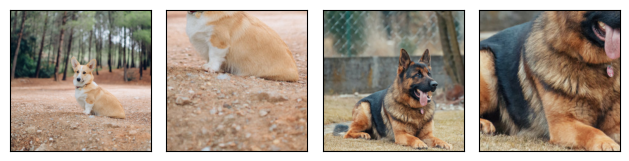

In [2]:
dog1 = decode_image(str(ASSETS_PATH / 'dog1.jpg'))
dog2 = decode_image(str(ASSETS_PATH / 'dog2.jpg'))

transforms = torch.nn.Sequential(
    v1.RandomCrop(224),
    v1.RandomHorizontalFlip(p=0.3),
)

scripted_transforms = torch.jit.script(transforms)

plot([dog1, scripted_transforms(dog1), dog2, scripted_transforms(dog2)])


v2转换也支持torchscript，但是如果你在 v2 **类** 转换上调用 {func}`torch.jit.script`，实际上你会得到它的（脚本化的）v1 等价物。这可能会导致脚本化执行与急切执行之间由于v1和v2实现差异而产生略有不同的结果。

如果你确实需要为v2转换提供torchscript支持，**建议脚本化** 来自 {func}`torchvision.transforms.v2.functional` 命名空间的功能函数，以避免意外。

下面我们现在展示如何结合图像变换和模型前向传递，同时使用 {func}`torch.jit.script` 来获得单一的脚本化模块。

让我们定义 ``Predictor`` 模块，该模块对输入张量进行变换，然后应用ImageNet模型。


In [3]:
from torchvision.models import resnet18, ResNet18_Weights


class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        self.resnet18 = resnet18(weights=weights, progress=False).eval()
        self.transforms = weights.transforms(antialias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            y_pred = self.resnet18(x)
            return y_pred.argmax(dim=1)

定义 ``Predictor`` 的脚本化和非脚本化实例，并将其应用在多个相同尺寸的张量图像上。

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

predictor = Predictor().to(device)
scripted_predictor = torch.jit.script(predictor).to(device)

batch = torch.stack([dog1, dog2]).to(device)

res = predictor(batch)
res_scripted = scripted_predictor(batch)

可以证实，脚本化模型与非脚本化模型的预测结果是相同的。

In [5]:
import json

with open(Path('../images') / 'imagenet_class_index.json') as labels_file:
    labels = json.load(labels_file)

for i, (pred, pred_scripted) in enumerate(zip(res, res_scripted)):
    assert pred == pred_scripted
    print(f"Prediction for Dog {i + 1}: {labels[str(pred.item())]}")

Prediction for Dog 1: ['n02113023', 'Pembroke']
Prediction for Dog 2: ['n02106662', 'German_shepherd']


由于该模型是基于脚本的，所以它可以被方便地存储在磁盘上并重复使用。

In [6]:
import tempfile

with tempfile.NamedTemporaryFile() as f:
    scripted_predictor.save(f.name)

    dumped_scripted_predictor = torch.jit.load(f.name)
    res_scripted_dumped = dumped_scripted_predictor(batch)
assert (res_scripted_dumped == res_scripted).all()